In [633]:
import numpy as np
import matplotlib.pyplot as plt
def softmax(matrix):
    return np.exp(matrix)/np.sum(np.exp(matrix), axis = 1).reshape(len(matrix[:,0]),1)
def tander(Z):
    return 1-np.multiply(Z,Z)
def relu(Z):
    return np.maximum(Z,0)
def reluder(Z):
    X = Z
    X[X>0] = 1
    X[X<=0] = 0
    return X
def sigmoid(Z):
    return 1/(1+np.exp(-Z))
def sigder(Z):
    return np.multiply(sigmoid(Z),1-sigmoid(Z))
def ident(Z):
    return Z
def GCEC(Y,Yhat):
    return -np.sum(np.multiply(Y,np.log(Yhat)))/len(Y[:,0])
def SSE(Y,Yhat):
    return np.sum(np.multiply(Y-Yhat,Y-Yhat))/len(Y[:,0])
def FroNorm(Y,Yhat):
    return np.trace((Y-Yhat).T@(Y-Yhat))/len(Y[:,0])
def BCEC(Y, Yhat):
    return -np.sum(np.multiply(Y,np.log(Yhat))+np.multiply((1-Y),np.log(1-Yhat)))/len(Y[:,0])
    
class TSNN:
    def __init__(self, nodes = [5,3,6,3],indims = 2,
                 activation = "tanh", taskType = 'regression'):
        self.layers = len(nodes)
        self.indims = indims
#         self.outdims = outdims
        self.nodes = nodes
        self.taskType = taskType
        if activation == "tanh":
            self.activation = np.tanh
            self.actder = tander
        elif activation == "relu":
            self.activation = relu
            self.actder = reluder
        elif activation == "sigmoid":
            self.activation = sigmoid
            self.actder = sigder
        else:
            print("The activation provided is not currently supported.\n Please select one of the following:\n tanh, sigmoid, relu.")
        if taskType == 'regression' or taskType == 'r':
            self.outputactivation = ident
            if self.nodes[-1] == 1:
                self.costfunc = SSE
            else:
                self.costfunc = FroNorm
        elif taskType == 'classification' or taskType == 'c':
            if self.nodes[-1] == 1:
                self.outputactivation = sigmoid
                self.costfunc = BCEC
            else:
                self.outputactivation = softmax
                self.costfunc = GCEC
        else:
            print("Please set taskType equal to classification or regression.")
        self.weights = {}
        self.biases = {}
    def weightInitialization(self):
        self.weights['w0']=np.random.randn(self.indims,self.nodes[0])
        self.biases['b0'] = np.random.randn(1,self.nodes[0])
        for i in range(1,self.layers):
            self.weights['w'+str(i)] = np.random.randn(self.nodes[i-1],self.nodes[i])
            self.biases['b'+str(i)] = np.random.randn(1,self.nodes[i])
    def predict(self, X):
        if(len(self.weights) == 0):
            print("Weights not previously initialized. Initializing now.")
            self.weightInitialization()
        self.Z = {}
        self.Z['0'] = X
        for i in range(1,len(self.nodes)):
            self.Z[str(i)] = self.activation(
                self.Z[str(i-1)]@self.weights['w'+str(i-1)]
                +self.biases['b'+str(i-1)])
        self.probabilities = self.outputactivation(
            self.Z[str(len(self.nodes)-1)]@self.weights['w'+str(
                self.layers-1)] + self.biases['b'+str(self.layers- 1)])
        if self.taskType == 'regression' or self.taskType == 'r':
            self.prediction = self.probabilities
        else:
            if self.nodes[-1] == 1:
                self.prediction = np.round(self.probabilities)
            else:
                self.prediction = np.eye(
                    self.probabilities.shape[1])[np.argmax(
                    self.probabilities,axis = 1)][:,0,:]
        return self.prediction
    def train(self, X,Y,Xval = [],Yval = [], epochs = 100, learningRate = .00001):
        if(len(self.weights) == 0):
            print("Weights not previously initialized. Initializing now.")
            self.weightInitialization()
        errs = []
        if len(Xval) == 0:
            Xval = X
            Yval = Y
        for i in range(0,epochs):
            js = np.linspace(len(self.weights)-1,0,len(self.weights))
            self.predict(X)
            d = self.probabilities - Y
            for j in range(len(self.weights)-1,-1,-1):
                self.weights['w'+str(j)] = self.weights['w'+str(j)]- learningRate*self.Z[str(j)].T@d
                self.biases['b'+str(j)] = self.biases['b'+str(j)]\
                - learningRate*np.sum(d,axis = 0)
                d = np.multiply(d@self.weights['w'+str(j)].T,
                                self.actder(self.Z[str(j)]))
            self.predict(Xval)
            errs.append(self.costfunc(Yval,self.probabilities))
        plt.plot(errs)
class TSLogisticRegression:
    def __init__(self,features, outputs):
        self.features = features
        self.outputs = outputs
        self.weight = []
        if outputs == 1:
            self.costfunc = BCEC
            self.activation = sigmoid
        else:
            self.costfunc = GCEC
            self.activation = softmax
    def weightInitialization(self):
        self.weight = np.random.randn(self.features+1,self.outputs)
    def predict(self,X):
        if not np.min(X[0,]) == 1 and np.max(X[0,]) == 1:
            X = np.column_stack((np.ones(len(X[:,0])),X))
        if len(self.weight) == 0:
            self.weightInitialization()
        self.probabilities = self.activation(X@self.weight)
        if self.outputs == 1:
            self.prediction = np.round(self.probabilities)
        else:
            self.prediction = np.eye(
                self.probabilities.shape[1])[np.argmax(
                self.probabilities,axis = 1)][:,0,:]
        return self.prediction
    def train(self,X,Y,Xval = [],Yval =[],
              lr = .00001, epochs = 100, l1 = 0, l2 = 0):
        err = []
        if Xval == []:
            Xval = X
            Yval = Y
        if not (np.min(X[0,]) == 1 and np.max(X[0,]) == 1):
            X = np.column_stack((np.ones(len(X[:,0])),X))
            Xval = np.column_stack((np.ones(len(Xval[:,0])),Xval))
        for i in range(0,epochs):
            self.predict(X)
            self.weight = self.weight - lr*X.T@(self.probabilities-Y) - l1*np.sign(self.weight) - l2*self.weight
            self.predict(Xval)
            err.append(self.costfunc(Yval,self.probabilities))
        plt.plot(err)
class TSRegression:
    def __init__(self,features, outputs):
        self.features = features
        self.outputs = outputs
        self.weight = []
        if outputs == 1:
            self.costfunc = SSE
            self.activation = ident
        else:
            self.costfunc = FroNorm
            self.activation = ident
    def weightInitialization(self):
        self.weight = np.random.randn(self.features+1,self.outputs)
    def predict(self,X):
        if not np.array_equal(
            X[:,0].T,np.matrix(np.ones(len(X[:,0].tolist())))):
            X = np.column_stack((np.ones(len(X[:,0])),X))
        if len(self.weight) == 0:
            self.weightInitialization()
        self.prediction = self.activation(X@self.weight)
#         if self.outputs == 1:
#             self.prediction = np.round(self.probabilities)
#         else:
#             self.prediction = np.eye(
#                 self.probabilities.shape[1])[np.argmax(
#                 self.probabilities,axis = 1)][:,0,:]
        return self.prediction
    def train(self,X,Y,Xval = [],Yval =[],
              lr = .00001, epochs = 100, l1 = 0, l2 = 0, closedForm = 'False'):
        if not np.array_equal(
            X[:,0].T,np.matrix(np.ones(len(X[:,0].tolist())))):
            X = np.column_stack((np.ones(len(X[:,0])),X))
        if closedForm == 'True':
            self.weights = np.linalg.inv(
                X.T@X+l2*np.identity(len(X.T[:,0])))@X.T@Y
        else:
            err = []
            if Xval == []:
                Xval = X
                Yval = Y
#             X = np.column_stack((np.ones(len(X[:,0])),X))
#             Xval = np.column_stack((np.ones(len(Xval[:,0])),Xval))
            for i in range(0,epochs):
                self.predict(X)
                self.weight = self.weight - lr*X.T@(self.prediction-Y) - l1*np.sign(self.weight) - l2*self.weight
                self.predict(Xval)
                err.append(self.costfunc(Yval,self.prediction))
            plt.plot(err)


In [634]:
model = TSNN( indims = 4, nodes = [2,6,6,6,1],activation = 'tanh', taskType = 'c')
# model.weightInitialization()
X = np.matrix(np.random.randn(150,4))
Y = np.rint(np.multiply(X,X))
Y = np.rint((Y-np.min(Y))/(np.max(Y)-np.min(Y)))[:,0]
# r = model.predict(X)

Weights not previously initialized. Initializing now.


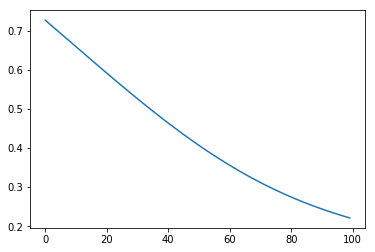

In [635]:
model.train(X,Y)

In [636]:
newmodel = TSLogisticRegression(len(X[0,].tolist()[0]), 1)

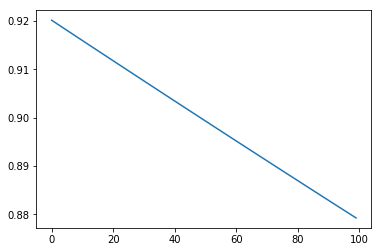

In [637]:
newmodel.train(X,Y,l1 = .0001)

In [496]:
np.array_equal(np.column_stack((np.ones(len(X[:,0])),X))[:,0],np.matrix(np.ones(len(X[:,0].tolist()[0]))))

False

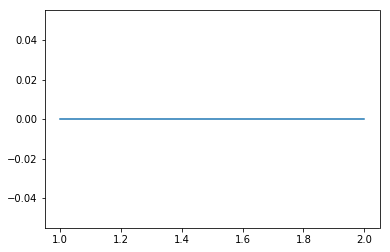

In [542]:
plt.plot([1,2],[SSE(Y,Y),SSE(Y,Y)])

In [629]:
# newnewmodel = TSRegression(len(X[0,].tolist()[0]), 1)
newnewmodel.train(X,Y, closedForm='True')
newnewmodel.weight
newnewmodel.prediction

matrix([[ 0.0342726 ],
        [ 0.06125811],
        [-0.02795813],
        [ 0.06889766],
        [-0.0087532 ],
        [ 0.02525171],
        [ 0.03677046],
        [ 0.05556165],
        [ 0.05912887],
        [ 0.05242894],
        [ 0.01858982],
        [ 0.0485083 ],
        [-0.00572152],
        [-0.04213328],
        [-0.01150642],
        [ 0.00632801],
        [-0.00118458],
        [ 0.0438968 ],
        [ 0.03672216],
        [-0.02404992],
        [ 0.05604095],
        [ 0.00476924],
        [ 0.02255128],
        [ 0.0753147 ],
        [ 0.15048285],
        [ 0.02996008],
        [ 0.03966463],
        [ 0.06988967],
        [ 0.01835788],
        [ 0.0588077 ],
        [ 0.07697259],
        [ 0.00103095],
        [ 0.09078225],
        [ 0.01367903],
        [ 0.11931802],
        [ 0.01189627],
        [ 0.04514732],
        [ 0.0602349 ],
        [-0.00839384],
        [-0.03451576],
        [ 0.06899591],
        [ 0.03449512],
        [ 0.05970399],
        [ 0

In [508]:
np.column_stack((np.ones(len(X[:,0])),X))[:,0].T

matrix([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.]])

In [374]:
Ynew = np.argmax(Y, axis = 1)
newphat = np.eye(model.prediction)[np.argmax(model.prediction,axis = 1)][:,0,:]
print(np.mean(np.rint(model.prediction) == Ynew))
print(np.sum(np.multiply(np.rint(newphat),Y), axis = 0)/np.sum(Y, axis = 0))

IndexError: too many indices for array

In [630]:
Y

matrix([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      